In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import os, json, requests, pickle
from scipy.stats import skew
from shapely.geometry import Point,Polygon,MultiPoint,MultiPolygon
from scipy.stats import ttest_ind, f_oneway, lognorm, levy, skew, chisquare
from sklearn.preprocessing import normalize, scale
from tabulate import tabulate #for printing pretty tables
from shapely.geometry import Point,Polygon,MultiPoint
%matplotlib inline

import warnings 
warnings.filterwarnings('ignore')

# NYC Green Taxi

Welcome! In this notebook, we will explore data from the New York City Green Taxi, the city's platform which uploads monthly datasets detailing Green Taxis' trips in and around the city. I have selected to work with the [December 2018](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page). Briefly, this study consists of some Explolatory Data Analysis (EDA) and model building that would predict the percentage tip a driver would expect on each trip. The below code chunk loads the dataset (with a local path) and prints out its dimensions (number of rows and columns). Some of the libraries worth pointing out include but are not limited to:

[shapely](https://pypi.org/search/?q=pandas)

[scikitlearn](https://scikit-learn.org/stable/)

[Tabulate](https://txt.arboreus.com/2013/03/13/pretty-print-tables-in-python.html)

## Warm Up Questions
 The few following code chunks will explore different questions one could ask about the dataset. Questions such as how many predictors or observations are we dealing with in this study, the distribution of some of the continuous variables like trip distance (very important variables to look at when predicting the tip percentage to be paid), the relationship the trip's datetime and distance traveled, meaning when do we seem to see longer trips being made? morning? Or evening hours?

In [2]:
url = "https://s3.amazonaws.com/nyc-tlc/trip+data/green_tripdata_2018-12.csv"
data = pd.read_csv(url)
data.to_csv(url.split('/')[-1])


# Print the size of the dataset
print("Number of rows:", data.shape[0]) # Number of rows
print("Number of columns:", data.shape[1]) # Number of columns

# create backup dataset
backup_data = data.copy()

Number of rows: 685373
Number of columns: 19


In [3]:
data.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type
0,2,2018-12-01 00:23:25,2018-12-01 00:24:47,N,1,193,193,1,0.00,3.0,0.5,0.5,0.00,0.0,NaN,0.3,4.30,2,1.0
1,2,2018-11-30 23:58:31,2018-12-01 00:21:53,N,1,80,82,2,5.75,21.0,0.5,0.5,0.00,0.0,NaN,0.3,22.30,2,1.0
2,2,2018-12-01 00:21:03,2018-12-01 00:30:15,N,1,225,225,1,1.55,8.0,0.5,0.5,1.86,0.0,NaN,0.3,11.16,1,1.0
3,2,2018-12-01 00:15:56,2018-12-01 00:23:26,N,1,75,236,2,1.32,7.0,0.5,0.5,0.00,0.0,NaN,0.3,8.30,1,1.0
4,2,2018-12-01 00:28:32,2018-12-01 00:30:33,N,1,75,75,2,0.68,4.0,0.5,0.5,1.06,0.0,NaN,0.3,6.36,1,1.0


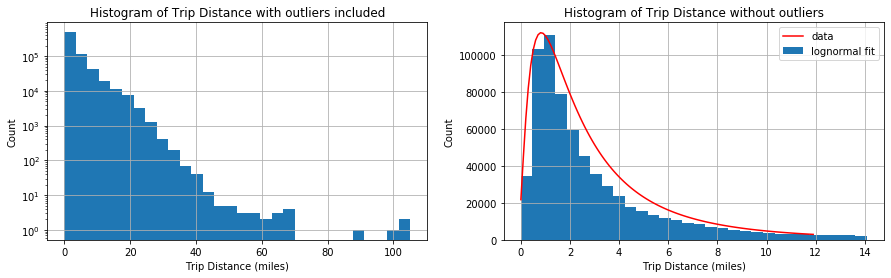

In [33]:
# define the figure with 2 subplots
fig,ax = plt.subplots(1,2,figsize=(15,4))

# Distribution of trip distance as a histogram plot
data.trip_distance.hist(bins=30,ax=ax[0])
ax[0].set_xlabel('Trip Distance (miles)')
ax[0].set_ylabel('Count')
ax[0].set_yscale('log')
ax[0].set_title('Histogram of Trip Distance with outliers included')

# define trip distance as a vector v
v = data.trip_distance
# exclude any data located further than 3 standard deviation away from the mean
v[~((v-v.median()).abs()>3*v.std())].hist(bins=30,ax=ax[1])
ax[1].set_xlabel('Trip Distance (miles)')
ax[1].set_ylabel('Count')
ax[1].set_title('Histogram of Trip Distance without outliers')

# apply a lognormal fit using the mean of trip distance as the scale parameter
scatter,loc,mean = lognorm.fit(data.trip_distance.values,
                              scale=data.trip_distance.mean(),
                              loc=0)
pdf_fitted = lognorm.pdf(np.arange(0,12,0.1), scatter,loc,mean)
ax[1].plot(np.arange(0,12,0.1),400000*pdf_fitted,'r')
ax[1].legend(['data','lognormal fit'])

# export the figure
plt.savefig('Question2.jpeg', format='jpeg')
plt.show()

To the right, outliers have been removed and the trip distance variable is asymmetrically distributed (shows right skewness), meaning the median is greater than the mean. The trip distance traveled cannot be negative. To the left, the histogram depicts the entire raw data for trip distance which includes outliers. Outliers were defined as any point located 3 standard deviations away from the mean.

Below, I will convert pick up and dropoff times to their right format then plot some useful visualizations to study the relationship between the distance traveled and time of day.

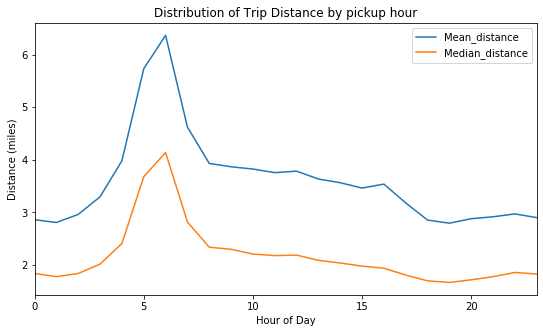

-----Trip distance by hour of the day-----

  Hour    Mean distance    Median distance
------  ---------------  -----------------
     0          2.86262               1.84
     1          2.80991               1.78
     2          2.96341               1.84
     3          3.29851               2.02
     4          3.98302               2.41
     5          5.73226               3.68
     6          6.36733               4.14
     7          4.62449               2.82
     8          3.9326                2.34
     9          3.86883               2.3
    10          3.82598               2.21
    11          3.7578                2.18
    12          3.7853                2.19
    13          3.63649               2.09
    14          3.56566               2.04
    15          3.4641                1.98
    16          3.53948               1.94
    17          3.18084               1.81
    18          2.85526               1.7
    19          2.79707               1.67
    20      

In [4]:
# convert pickup and dropoff features into the right format
data['Pickup_dt'] = data.lpep_pickup_datetime.apply(lambda x:dt.datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))
data['Dropoff_dt'] = data.lpep_dropoff_datetime.apply(lambda x:dt.datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))

# creating a variable for pickup hours
data['Pickup_hour'] = data.Pickup_dt.apply(lambda x:x.hour)

# Mean and Median of trip distance by pickup hour
# An intuitive table along with a visualization plot will be constructed below

fig,ax = plt.subplots(1,1,figsize=(9,5)) # prepare fig to plot mean and median values
# use a pivot table to aggregate trip distance by pickup hour
table_pivot = data.pivot_table(index='Pickup_hour', values='trip_distance',
                              aggfunc=('mean','median')).reset_index()
# renaming columns
table_pivot.columns = ['Hour','Mean_distance','Median_distance']
table_pivot[['Mean_distance','Median_distance']].plot(ax=ax)
plt.xlabel("Hour of Day")
plt.ylabel('Distance (miles)')
plt.title('Distribution of Trip Distance by pickup hour')
# defining x-axis limits
plt.xlim([0,23])
plt.savefig('Question3_1.jpeg', format='jpeg')
plt.show()
# printing table with tabulate and plotting time series graph
print('-----Trip distance by hour of the day-----\n')
print(tabulate(table_pivot.values.tolist(),["Hour","Mean distance","Median distance"]))

From the plot or table, we observe a mean/median increase in miles traveled early in the mornings throughout the month of December 2018. This could mean many customers are rushing to work during those times.The same trend is not seen in evening hours maybe because not all customers get off work at the same time (5 pm being standard).

**Let's explore trips to/from both JFK and Newark (NJ) airports next**

As the [variable dictionary](https://www1.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_green.pdf) defines it, there were two airports: JFK (represented by the dummy variable "2") and Newark (represented by the dummy variable "3"). The below chunk looks at the number of trips made to/from both airports, the mean fare amount charged, and the average total amount (before tips) charged to customers.

In [5]:
# select airport trips
airport_trips = data[(data.RatecodeID == 2) | (data.RatecodeID == 3)]
print("Number of trips to/from both airports: ", airport_trips.shape[0])
print("Average fare (calculated by meter) of trips to/from both airports: $", round(airport_trips.fare_amount.mean(),2),"per trip")
print("Average total amount charged (before tip) to/from both airports: $", round(airport_trips.total_amount.mean(), 2),"per trip")

Number of trips to/from both airports:  1525
Average fare (calculated by meter) of trips to/from both airports: $ 51.2 per trip
Average total amount charged (before tip) to/from both airports: $ 63.42 per trip


The fare amount is not the same as the total amount charged maybe because the meter only takes into account the distance traveled and not the time spent on the road. Next, I will visualize the distribution of distance traveled to/from both airports in relation to time of day.

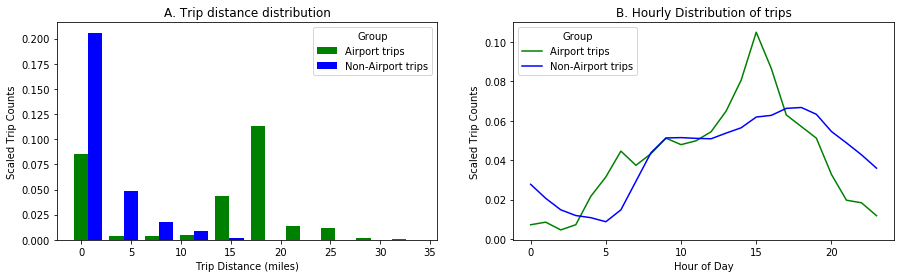

In [6]:
# creating vector to contain trip distance
t = airport_trips.trip_distance # airport trips
z = data.loc[~data.index.isin(t.index),'trip_distance'] # non-airport trips

# Getting rid of outliers in both vectors
# I will exclude any points located 3 standard deviations away from the mean
t = t[~((t-t.mean()).abs()>3*t.std())]
z = z[~((z-z.mean()).abs()>3*z.std())]

# defining bins boundaries
bins = np.histogram(t,normed=True)[1]
h2 = np.histogram(t,bins=bins,normed=True)
h3 = np.histogram(z,bins=bins,normed=True)

# plot distributions of trip distance normalized among groups
fig,ax = plt.subplots(1,2,figsize=(15,4))
g = .4*(bins[1]-bins[0])
ax[0].bar(bins[:-1],h2[0],alpha=1,width=g,color='g')
ax[0].bar(bins[:-1]+g,h3[0],alpha=1,width=g,color='b')
ax[0].set_title('A. Trip distance distribution')
ax[0].set_xlabel('Trip Distance (miles)')
ax[0].set_ylabel('Scaled Trip Counts')
ax[0].legend(['Airport trips', 'Non-Airport trips'],loc='best',title='Group')

# plot hourly distribution
airport_trips.Pickup_hour.value_counts(normalize=True).sort_index().plot(ax=ax[1], color='g')
data.loc[~data.index.isin(t.index),'Pickup_hour'].value_counts(normalize=True).sort_index().plot(ax=ax[1], color='b')
ax[1].set_title('B. Hourly Distribution of trips')
ax[1].set_xlabel('Hour of Day')
ax[1].set_ylabel('Scaled Trip Counts')
ax[1].legend(['Airport trips','Non-Airport trips'],loc='best',title='Group')
plt.savefig('Question3_2.jpeg', format='jpeg')
plt.show()

The plot on the **left** shows scaled trip counts in relation to the trip's distance. obviously, there would be multiple non-airport trips as most folks just move around the city and not necessarily headed for either of the airports. This is explained by the two tall bars at the beginning, where the non-airport bar (blue) might mean customers were moving around manhattan whereas the airport trips (green) might mean airport employees, living in the airport proximities, would need the green taxi to get to/from work OR just usual customers going to/from the airports. We also see a tall Green bar at about 18 miles range, which might represent customers coming from/going to either airports from/to their homes in manhattan or elsewhere.

The plot on the **right** shows scaled trip counts in relation to the hour of day. For the airport trips, we see two peaks, both around 5AM and 3PM, the usual times a customer is required to be at the airport for checkins whether they are flying in the morning or evening. For the non-airport trips, there is a bump in trip counts both in the mornings and evenings, meaning customers are going to work and coming from work respectively.

# Introduction
The original dataset is comprised of **685373** observartions and **19** variables (both categorical and continuous). This study follows 4 main sections: Data cleaning, feature engineering, explolatory data analysis, and finally model building. For model building, both **RandomForest** and **Gradient Boosting** algorithms were optimized and used to predict percentage tip. The decision to use These models came from analyzing the relationship between predictor variables and response (percentage tip) variable. The relationship in question was found to be non-linear, so I decided to use models that do not require there to be any assumptions. Tree-Based methods such as *RF* and *Gradient Boosting* are suitable for this task.
## Data Cleaning
The cleaning process consisted of replacing missing values using appropriate missing value imputation techniques such as using the **Mean** for continuous covariates or **Mode** for categorical covariates. 

* During this process, I dropped the **Ehail_fee** variable as it was 100% comprised of missing values therefore had no variance. 
* The two missing values in the *trip_type* variable were replace by the most occuring value (mode). **Used: data.isnull().sum()**
* Invalid data for certain columns:
    * Per the variable disctionary, there is not supposed to be a **99** as a dummy value for **RatecodeID**, so I replaced the three 99s with the most occuring value. **Used: (data['extra'].count_values().sum())**
    * Extra: 0.09% of transactions were negative. These were replaced by 0 as the most frequent. **Used: (sum(i for i in data.improvement_surcharge if i < 0)**
    * For continuous variables, if a negative value was found, it was replaced by its absolute value (assuming a data entry error was made) since transaction amounts cannot be negative. Additionally, as the minimum total_amount chargeable for any taxi service is $2.5$, every transaction falling below this value was replaced by the median of total_amount (median=$12.18$).


**Reloading the dataset here below:**

In [2]:
url = "https://s3.amazonaws.com/nyc-tlc/trip+data/green_tripdata_2018-12.csv"
data = pd.read_csv(url)
data.to_csv(url.split('/')[-1])


# Print the size of the dataset
print("Number of rows:", data.shape[0]) # Number of rows
print("Number of columns:", data.shape[1]) # Number of columns

# create backup dataset
backup_data = data.copy()

Number of rows: 685373
Number of columns: 19


In [3]:
# define a function to clean the dataset

def clean_data(adata):
    """
    This function cleans the dataset by removing unncessasary variables, replacing missing values with meaningful
    values, getting rid of negative amount values and converting the time variable into its right format.
    input:
        adata: pandas.dataframe
    output:
        pandas.dataframe
    """
    ## drop ehail_fee column
    if 'ehail_fee' in data.columns:
        data.drop('ehail_fee',axis=1,inplace=True)
        
    ## replace missing values in trip_type with the most frequent value 1
    data['trip_type']=data['trip_type'].replace(np.NaN,1)
    
    ## replace all values that are not allowed as per the variable dictionary with the most frequent allowable value
    ### percentages of negative values per column
    print("Negative values found and replaced by their absolute values")
    print("total_amount", 100*data[data.total_amount<0].shape[0]/float(data.shape[0]),"%")
    print("tip_amount", 100*data[data.tip_amount<0].shape[0]/float(data.shape[0]),"%")
    print("fare_amount", 100*data[data.fare_amount<0].shape[0]/float(data.shape[0]),"%")
    print("tolls_amount", 100*data[data.tolls_amount<0].shape[0]/float(data.shape[0]),"%")
    print("mta_tax", 100*data[data.mta_tax<0].shape[0]/float(data.shape[0]),"%")
    print("improvement_surcharge", 100*data[data.improvement_surcharge<0].shape[0]/float(data.shape[0]),"%")
    ### remove negative values from the afore metioned continuous variables above
    data.total_amount = data.total_amount.abs()
    data.tip_amount = data.tip_amount.abs()
    data.fare_amount = data.fare_amount.abs()
    data.tolls_amount = data.tolls_amount.abs()
    data.mta_tax = data.mta_tax.abs()
    data.improvement_surcharge = data.improvement_surcharge.abs()
    
    # Extra
    indices_oi = data[~((data.extra==0) | (data.extra==0.5) | (data.extra==1))].index
    data.loc[indices_oi, 'extra'] = 0 # 0 was the mode of this variable
    print(round(100*len(indices_oi)/float(data.shape[0]),2),"% of values in extra were invalid and were replaced by the most frequent 0")
    
    # RatecodeID
    indices_oi = data[~((data.RatecodeID>=1) | (data.RatecodeID<=6))].index
    data.loc[indices_oi, 'RatecodeID'] = 1 # 1 was the mode for this variable
    print(round(100*len(indices_oi)/float(data.shape[0]),2),"% of values in RatecodeID were invalid and were replaced by the most frequent 1")
    
    # total_amount: the minimum charge is 2.5, so I replaced values less than 2.5 with the median 12.18
    indices_oi = data[(data.total_amount<2.5)].index
    data.loc[indices_oi,'total_amount'] = 12.18
    print(round(100*len(indices_oi)/float(data.shape[0]),2), "% of values in total amount less than 2.5 and were replaced by the median 12.18")
    
    # encode categorical to numeric
    if data.store_and_fwd_flag.dtype.name != 'int64':
        data['store_and_fwd_flag'] = (data.store_and_fwd_flag=='Y')*1
    
    # rename time stamp variable and convert to right format
    print("renaming variables...")
    data.rename(columns={'lpep_pickup_datetime':'Pickup_dt', 'lpep_dropoff_datetime':'Dropoff_dt'}, inplace=True)
    print("converting timestamps variables to right format...")
    data['Pickup_dt'] = data.Pickup_dt.apply(lambda x:dt.datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))
    data['Dropoff_dt'] = data.Dropoff_dt.apply(lambda x:dt.datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))
    
    print("Done Cleaning")
    return data

In [4]:
# Run code to clean the entire dataset
data = clean_data(data)

Negative values found and replaced by their absolute values
total_amount 0.2960431764892985 %
tip_amount 0.002918119038829951 %
fare_amount 0.2960431764892985 %
tolls_amount 0.00014590595194149755 %
mta_tax 0.2865592896131012 %
improvement_surcharge 0.28232801700679777 %
0.17 % of values in extra were invalid and were replaced by the most frequent 0
0.0 % of values in RatecodeID were invalid and were replaced by the most frequent 1
0.21 % of values in total amount less than 2.5 and were replaced by the median 12.18
renaming variables...
converting timestamps variables to right format...
Done Cleaning


## Feature Engineering
In this section, I intuitively created new variables off of existing ones. 

* **Time variables:** Here time-dependent variables such as **week, day_of_month, day_of_week, hour_of_day, shift_type, trip_duration** were created. These variables could help in determining whether or not a client might be willing to tip depending on the time the trip took place. For example, customers might be willing to tip on weekends, at the end of the second and forth weeks which corresponds to when they receive their paychecks, etc.

* **Speed:** This variable is the ration of trip distance to trip duration. Data points (cabs) surpassing the 240mph threshold were dropped since that is the top speed most cars have. 

* **With Tip:** This is a binary variable indicating whether or not a tip was provided. This variable would come in handy since no tip was given in the majority (60%) of trips.

* Tip Percentage: This is the response variable, which is calculated by taking the ratio of the tip_amount to total_amount times 100.


**N.B:** if we had coordinates of where the trip originated and where it terminated, we could create two variables that answeres the questions: Was the cab traveling in a vertical direction? Meaning North to South (Direction_NS)? Or was the cab traveling in a horizontal direction? Meaning East to West (Direction_EW)?

In [5]:
# Creating a function for feature engineering described above
def engineer_features(adata):
    """
    This function helps create new variables for the dataset in question. Variables include:
    . week: int {1,2,3,4,5}, week a transaction was made
    . day_of_month: int [0-30], day of month a transaction was made
    . day_of_week: int [0-6], day of the week a transaction was made
    . hour_of_day: int [0-23], hour of day a transaction was made
    . trip_duration: float, time it takes to complete the trip
    . shift_type: int {1=(7am-3pm), 2=(3pm-11pm), 3=(11pm-7am)}, shift of day a transaction was made
    . speed_mph: float, speed of the trip
    . with_tip: int {0,1}, 1=transaction with tip, 0=transaction without tip
    . Tip_percentage: float, response variable
    
    input:
        adata: pandas.dataframe
    output:
        pandas.dataframe
    """
    
    # make a copy of original dataset
    data = adata.copy()
    
    # create time variables
    print("creating time variables...")
    ref_week = dt.datetime(2018,12,1).isocalendar()[1] # first week of december 2018
    data['week'] = data.Pickup_dt.apply(lambda x:x.isocalendar()[1])-ref_week+1
    data['day_of_week'] = data.Pickup_dt.apply(lambda x:x.isocalendar()[2])
    data['day_of_month'] = data.Pickup_dt.apply(lambda x:x.day)
    data['hour_of_day'] = data.Pickup_dt.apply(lambda x:x.hour)
    
    # Shift type: 1=(7am to 3pm), 2=(3pm to 11pm), 3=(11pm to 7am)
    print("creating shift type...")
    data['shift_type'] = np.NAN
    data.loc[data[(data.hour_of_day>=7) & (data.hour_of_day<15)].index, 'shift_type'] = 1
    data.loc[data[(data.hour_of_day>=15) & (data.hour_of_day<23)].index, 'shift_type'] = 2
    data.loc[data[data.shift_type.isnull()].index, 'shift_type'] = 3
    
    # Trip duration
    print("Creating trip duration...")
    data['trip_duration'] = ((data.Dropoff_dt-data.Pickup_dt).apply(lambda x:x.total_seconds()/60.))
    
    # Speed (in mph)
    print("creating speed variable in mph...")
    data['speed_mph'] = data.trip_distance/(data.trip_duration/60)
    # replacing all NAN values and data points greater than 240mph by a value sampled from a random distribution
    # mean of 12.12mph and standard deviation of 6.9mph. These values were extracted from the normal distribution
    indices_oi = data[(data.speed_mph.isnull()) | (data.speed_mph>240)].index
    data.loc[indices_oi,'speed_mph'] = np.abs(np.random.normal(loc=12.12,scale=6.9,size=len(indices_oi)))
    
    # create tip percentage variable (response variable)
    print("creating Tip Percentage...")
    data['tip_percentage'] = 100*data.tip_amount/data.total_amount
    
    # create with_tip variable
    print("creating With Tip variable...")
    data['with_tip'] = (data.tip_percentage>0)*1
    
    print("Feature Engineering is Done!!!")
    
    return data

After conducting feature engineering, the **speed_mph** variable had multiple missing values and I imputed those missing values by replacing them by calues sampled from a random normal distribution. To do this, I forst determined the the mean and standard deviations of the *speed_mph* while ignoring the missing values, then used numpy's random.normal function to sample random speed values from a normal distribution. 

* **Sample code used for determining mean and std:** A = np.array(data['speed_mph']), np.nanmean(A), np.nanstd(A).

In [6]:
# run the function to create new features on the dataset
print("size before feature engineering:", data.shape)
data = engineer_features(data)
print("size after feature engineering:", data.shape)

size before feature engineering: (685373, 18)
creating time variables...
creating shift type...
Creating trip duration...
creating speed variable in mph...
creating Tip Percentage...
creating With Tip variable...
Feature Engineering is Done!!!
size after feature engineering: (685373, 27)


In [70]:
# Uncomment to check for data validity
# data.describe() .T

## Exploratory Data Analysis
In this section, I will study the relationship between variables, mainly the distribution of the response *tip_percentage* variable and the correlation between continuous predictor variables. Based on the information deduced in this section, I decided to build the model in two steps:

* Create a classification model to predict whether or not a Tip was given using the newly created variable **With_tip**.

* Create a regression model for transactions that included Tips.

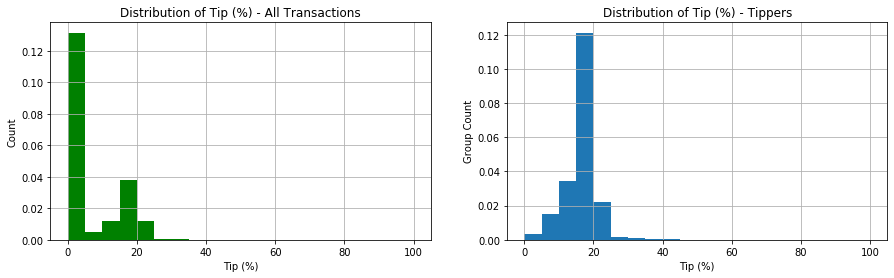

In [7]:
# comparison all transactions vs Tippers
## split data into two groups
data1 = data[data.tip_percentage>0]
data2 = data[data.tip_percentage==0]

## Generate histograms to compare
fig,ax = plt.subplots(1,2,figsize=(15,4))
data.tip_percentage.hist(bins=20,normed=True,ax=ax[0],color='g')
ax[0].set_xlabel('Tip (%)')
ax[0].set_ylabel('Count')
ax[0].set_title('Distribution of Tip (%) - All Transactions')


data1.tip_percentage.hist(bins=20,normed=True,ax=ax[1])
ax[1].set_xlabel('Tip (%)')
ax[1].set_ylabel('Group Count')
ax[1].set_title('Distribution of Tip (%) - Tippers')
plt.savefig('Question4_resp_var.jpeg', format='jpeg')
plt.show()

The plot on the left shows the distribution of *Tips* for all transactions in this dataset, where the majority of customers (~60%) did not tip (corresponsing to the larger peak at 0%). But the plot on the right representing the distribution of *Tip Percentage* for tippers shows a series of peaks, corresponding to the popular tipping range of 15%-20%, with the largest peak at **18%**.

Below, a set of functions were implimented to explore the relationships between predictor variables and the response, tip percentage, variable. Two main functions were build, first for the continuous variable exploration and second for the categorical variables exploration. The categorical variable functions was set up to generate either a *histogram* or a *boxplot* (STILL HAVE TO GET THE HISTOGRAM FUNCTION TO WORK-PROVEN-TO TAKE A LOT OF TIME). The third and final function visually and numerically (by statistical tests) explored the differences between customers who tipped and those who did not.

In [8]:
# Functions of Exploratory Data Analysis
## Continuous Variables
def visualize_continuous(df,label,method={'type':'histogram','bins':20},outlier='on'):
    """
    this funtion quickly visualizes continuous variables
    df: pandas.dataframe
    label: name of variable to be plotted. One of the columns in dataframe
    method: contains the info of the type of plot to be generated (histogram or boxplot)
    outlier: ON- to include outliers and OFF- to exclude outliers. Outliers are defined as any point located 3 standard
    deviations away from the mean.
    """
    
    # create vector of the variable of interest
    v = df[label]
    # define mean and standard deviation
    m = v.mean()
    s = v.std()
    # prep the figure
    fig,ax = plt.subplots(1,2,figsize=(15,4))
    ax[0].set_title('Distribution of '+label)
    ax[1].set_title('Tip % by '+label)
    if outlier=='off': # remove outliers accordingly and update titles
        v = v[(v-m)<=3*s]
        ax[0].set_title('Distribution of '+label+' (no outliers)')
        ax[1].set_title('Tip % by '+label+' (no outliers)')
    if method['type'] == 'histogram': # plot the histogram
        v.hist(bins=method['bins'],ax=ax[0])
    if method['type'] == 'boxplot': # plot the boxplot
        df.loc[v.index].boxplot(label,ax=ax[0])
    ax[1].plot(v,df.loc[v.index].tip_percentage,'.',alpha=0.5)
    ax[0].set_xlabel(label)
    ax[1].set_xlabel(label)
    ax[0].set_ylabel('Count')
    ax[1].set_ylabel('Tip (%)')
    

    
# comparing customers who tipped and those who did not   
def test_classification(df,label,yl=[0,50]):
    """
    This function test if the means of the groups, with_tip and without_tip, are significantly different at 0.05
    significance level.
    It will also generate a boxplot of the variable by tipping groups
    label: str, label to test
    yl: tuple pr list (default = [0,50]), is the feault limit of the y-axis on the boxplot
    df: pandas.dataframe (default = data)
    """
    
    if len(pd.unique(df[label]))==2: # check of the variable is categorical with only two categories then run a chi-squared test
        vals = pd.unique(df[label])
        gp1 = df[df.with_tip==0][label].value_counts().sort_index()
        gp2 = df[df.with_tip==1][label].value_counts().sort_index()
        print("chi-squared test if", label, "can be used to distinguish transaction with tip and without tip")
        print (chisquare(gp1,gp2))
    elif len(pd.unique(df[label]))>=10: # otherwise run the welch's t-test, which does not assume equal population variance
        df.boxplot(label,by='with_tip')
        plt.ylim(yl)
        plt.show()
        print("t-test if", label, "can be used to distinguish transaction with tip and without tip")
        print ("results:",ttest_ind(df[df.with_tip==0][label].values,df[df.with_tip==1][label].values,equal_var=False))
    else:
        pass
    
    
    
## Categorical variables
def visualize_categories(df,catName,chart_type='histogram',ylimit=[None,None]):
    """
    this function helps in visulaizing categorical variables.
    this functions calls other functions like generate_boxplot and generate_histogram
    df: pandas.dataframe
    catName: categorical variable in dataset
    chart_type: plot of choice to display (histogram or boxplot)
    ylimit: tuple or list. Valid if chart_type is a boxplot
    """
    
    # defining the categorical function
    print(catName)
    cats = sorted(pd.unique(df[catName]))
    if chart_type == 'boxplot': # generate boxplot
        generate_boxplot(df,catName,ylimit)
    elif chart_type == 'histogram': # generate histogram
        generate_histogram(df,catName)
    else:
        pass
    
    ## calculate test-statistic
    groups = df[[catName,'tip_percentage']].groupby(catName).groups # creating groups
    tips = df.tip_percentage
    if len(cats)<=2: # if there are only two groups use t-test
        print(ttest_ind(tips[groups[cats[0]]],tips[groups[cats[1]]]))
    else: # if there are more than 2 groups
        # prepare the command to evaluate the one-way anova
        cmd = "f_oneway("
        for cat in cats:
            cmd+="tips[groups["+str(cat)+"]],"
        cmd=cmd[:-1]+")"
        print("one way anova test:", eval(cmd)) # evaluate the command and print
    print("Frequency of categories (%):\n",df[catName].value_counts(normalize=True)*100)
    
    
## defining boxplot subfunction
def generate_boxplot(df,catName,ylimit):
    """
    generate boxplot of tip percentage by categorical variable (catName) with set ylimit
    df: pandas.dataframe
    catName: str
    ylimit: tuple, list
    """
    df.boxplot('tip_percentage',by=catName)
    plt.title('')
    plt.ylabel('Tip (%)')
    if ylimit != [None,None]:
        plt.ylim(ylimit)
    plt.show()
    
## defining histogram subfunction
def generate_histogram(df,catName):
    """
    generate histogram of tip percentage by variable "catName" with ylim set to ylimit
    df: pandas.Dataframe
    catName: str
    ylimit: tuple, list
    """
    cats = sorted(pd.unique(df[catName]))
    colors = plt.cm.jet(np.linspace(0,1,len(cats)))
    hx = np.array(map(lambda x:round(x,1),np.histogram(df.tip_percentage,bins=20)[1]))
    fig,ax = plt.subplots(1,1,figsize = (15,4))
    for i,cat in enumerate(cats):
        vals = df[df[catName] == cat].tip_percentage
        h = np.histogram(vals,bins=hx)
        w = 0.9*(hx[1]-hx[0])/float(len(cats))
        plt.bar(hx[:-1]+w*i,h[0],color=colors[i],width=w)
    plt.legend(cats)
    plt.yscale('log')
    plt.title('Distribution of Tip by '+catName)
    plt.xlabel('Tip (%)')

For the **visualize_continuous** function, when exploring the distribution of the *fare amount* while excluding outliers, the distribution was found to be right skewed, meaning the mean is lesser than the median (left plot). On the other hand, when exploring the relationship between *fare amount* and *tip percentage* while excluding outliers, it was found that most customers gave a 20% and below tip no matter the fare amount payed. 

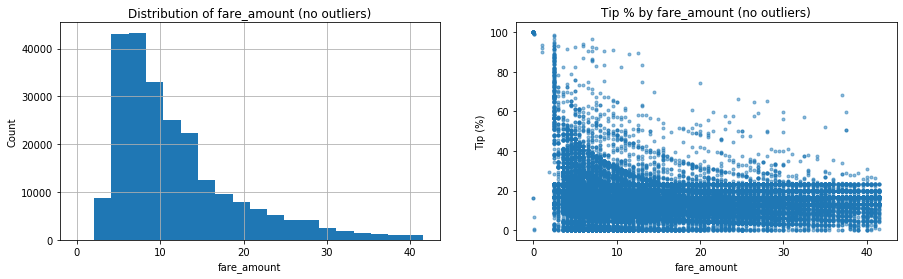

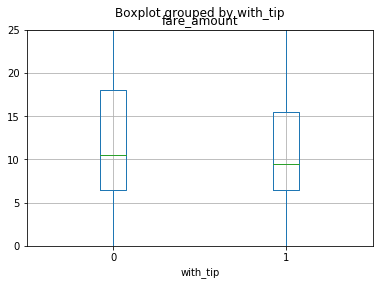

t-test if fare_amount can be used to distinguish transaction with tip and without tip
results: Ttest_indResult(statistic=79.74026194900446, pvalue=0.0)


In [9]:
visualize_continuous(data1,'fare_amount',outlier='off')
test_classification(data,'fare_amount',[0,25])

For the **test_classification** function, we reject the null hypothesis and conclude that the two groups (with tip and without tip) are significantly different at 0.05 significance level. Thus, with this hypothesis, I have decided the *with_tip* variable would be a significant contributor to predicting tip percentage and will therefore be used in building the classification model that predicts whether or not a tip was given.

Below, a correlation heat map was used to visualize the correlation between continuous variables. The chunk below provides the construction of the heat map.

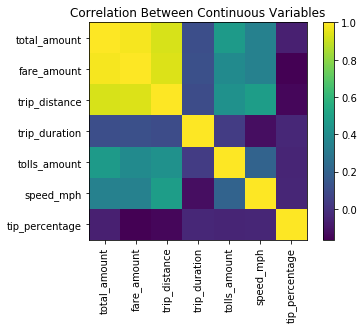

In [10]:
continuous_variables = ['total_amount','fare_amount','trip_distance','trip_duration','tolls_amount','speed_mph',
                       'tip_percentage']
# I will use the the dataset for customers who gave tips
cor_mat = data1[continuous_variables].corr()
plt.imshow(cor_mat)
plt.xticks(range(len(continuous_variables)),continuous_variables,rotation='vertical')
plt.yticks(range(len(continuous_variables)),continuous_variables)
plt.colorbar()
plt.title('Correlation Between Continuous Variables')
plt.show()

Some high correlations (above 0.5) were seen between *tolls_amount* and variables such as *total_amount, fare_amount, and trip_distance* and also between *speed_mph* and variables such as *total_amount, fare_amount, and trip_distance*. Highly correlated variables might be excluded from modeling the response variable, meaning one in any two highly correlated variables will be eliminated as a predictor of the *Tip percentage* response variable.

As for categorical variables, the **visualize_categories** function was used, generating both a histogram or boxplot depending on which was more intuitive.

payment_type


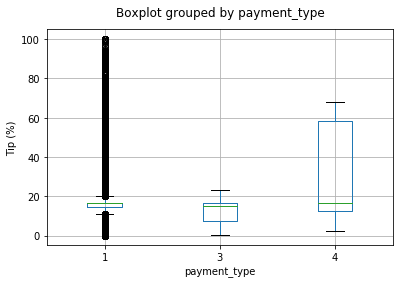

one way anova test: F_onewayResult(statistic=27.652436044986974, pvalue=9.819499007854318e-13)
Frequency of categories (%):
 1    99.991211
3     0.006697
4     0.002093
Name: payment_type, dtype: float64


In [11]:
visualize_categories(data1,'payment_type','boxplot')

The plot above compares the medians and range of tip percentage among the different payment methods used. All three payment methods show to have provided about the same median tip percentage but with different ranges. For example, the credit card payment method (represented by 1 and which happens to be the majority of customers-99.99%) shows a narrow range with most customers automatically giving 18% tip percentage. Also, with a p-value lesser than the 0.05 significance level, I reject the null hypothesis and conclude that the three payment methods are significantly different.

## Model Building
As mentioned above, two models, a classification and regression, will be built where the **classification model** will be deciding whether or not a tip was given as opposed to the **regression model** which will be estimating the tip percentage given if the tip was provided.

In [12]:
# import scikit learn libraries
from sklearn import model_selection, metrics # model optimization and evaluation tools
from sklearn.model_selection import GridSearchCV # performing grid search for tuning parameters in RF and Boosting

# defining a function to train and select optimal model using cross validation
def modelfit(alg,dtrain,predictors,response,scoring_method,performCV=True,printFeatureImportance=True,cv_folds=5):
    """"
    This function trains the model given as 'alg' by performing cross-validation. It works on both regression
    and classification.
    alg: sklearn model
    dtrain: pandas.DataFrame, training set
    predictors: list, labels to be used in the training process.
    response: str, the response variable
    scoring_method: str, cross-validation method used the evaluate model performance
    performCV: bool, perform CV or not
    printFeatureImportance: bool, plot histogram of feature importance or not
    cv_folds: int, dividing data into K equal sized parts for cross validation
    """
    
    # train the algorithm on training data
    alg.fit(dtrain[predictors],dtrain[response])
    # predict on portion of training data
    dtrain_predictions = alg.predict(dtrain[predictors])
    if scoring_method == 'roc_auc':
        dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    # perform cross-validation
    if performCV:
        cv_score = model_selection.cross_val_score(alg,dtrain[predictors],dtrain[response],cv=cv_folds,
                                                   scoring=scoring_method)
    # print model report
    print('\nModel report:')
    if scoring_method == 'roc_auc':
        print('Accuracy:',metrics.accuracy_score(dtrain[response].values,dtrain_predictions))
        print('AUC Score (Train):',metrics.roc_auc_score(dtrain[response],dtrain_predprob))
    if scoring_method == 'mean_squared_error':
        print('Accuracy:',metrics.mean_squared_error(dtrain[response].values,dtrain_predictions))
    if performCV:
        print('CV Score - Mean : %.7g | Std : %.7g | Min : %.7g | Max : %.7g' % (np.mean(cv_score),np.std(cv_score),
                                                                                np.min(cv_score),np.max(cv_score)))
    # print feature importance
    if printFeatureImportance:
        if dir(alg)[0] == '_Booster': # runs if alg is gradient boosting
            feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=True)
        else:
            feat_imp = pd.Series(alg.feature_importances_,predictors).sort_values(ascending=True)
        feat_imp.plot(kind='barh',title='Feature Importance')
        plt.xlabel('Feature Importance Score')
        plt.show()
        
        
# defining the optimization function that searches for the optimal tuning parameter
def optimize_num_trees(alg,param_test,scoring_method,train,predictors,response):
    """
    This function is used to to tune parameters of a predicitve algorithm
    alg: sklearn model
    param_test: dict, parameters to be tuned
    scoring_method: str, cross-validation method used the eveluate model performance
    train: pandas.Dataframe, training data
    predictors: list, labels to be used in the model training process
    response: str, response variable
    """
    gsearch = GridSearchCV(estimator=alg, param_grid = param_test,scoring=scoring_method,n_jobs=2,iid=False,cv=5)
    gsearch.fit(train[predictors],train[response])
    return gsearch

# defining the functions that plots optimization results
def plot_opt_results(alg):
    cv_results = []
    for i in range(len(param_test['n_estimators'])):
        cv_results.append((alg.grid_scores_[i][1],alg.grid_scores_[i][0]['n_estimators']))
    cv_results = pd.DataFrame(cv_results)
    plt.plot(cv_results[1],cv_results[0])
    plt.xlabel('# of Trees')
    plt.ylabel('Score')
    plt.title('Optimization Report')

### Classification Model
After spending a considerable amount of time on the Exploratory Data Analysis section, I found out that **payment_type** was the strongest covariate in determining the **with_tip** outcome as **99%** of payments were made using a credit card. Therefore, by optimizing the GradientBoostingClassifier (from scikit learn) model, I was able to obtain an accuracy score of **96%**. The GradientBoostingClassifier (GBM) model is composed of three tuning parameters: the number of trees, depth of trees, and the learning rate. The trees in the GBM model are built one at a time (which takes a long time) and they learn **slowly** since each new tree helps to correct errors made by the previously trained tree. A great application of GBM, and the main reason why it's used in this instance, is that it works well with highly unbalanced data such as DNA sequence or credit card transactions (like in this case).

**Worth Noting:**

* Sample size of training and optimization was chosen as 100000. This is a small sample size given the amount of observations we have (~600k) but is representative of the general population as it was selected randomly.
* ROC-AUC (Area under the curve from the receiver operating characteristic) was used as the model validation metric

**Results:**

* **optimized number of trees:** 110
* **optimized variables:** payment_type, total_amount, trip_duration, trip_distance, extra, shift_type, trip_type
* **roc-auc on the test dataset (for model performance purposes):** 96.18%

The following code shows the optimization process...

Optimizing the classifier...
{'mean_fit_time': array([ 3.16251931,  5.68544264,  7.12672496,  9.44775677, 11.29091368,
       13.41268382, 15.9232379 ]), 'std_fit_time': array([0.24317849, 0.6334006 , 0.18677254, 0.23725267, 0.22853958,
       0.34537476, 0.67828349]), 'mean_score_time': array([0.02562008, 0.03681035, 0.04247718, 0.05050411, 0.05771527,
       0.06526756, 0.07286954]), 'std_score_time': array([0.00314605, 0.00421998, 0.00074663, 0.00071483, 0.0011894 ,
       0.00071078, 0.00381468]), 'param_n_estimators': masked_array(data=[30, 50, 70, 90, 110, 130, 150],
             mask=[False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'n_estimators': 30}, {'n_estimators': 50}, {'n_estimators': 70}, {'n_estimators': 90}, {'n_estimators': 110}, {'n_estimators': 130}, {'n_estimators': 150}], 'split0_test_score': array([0.96265804, 0.9803145 , 0.98627762, 0.98938153, 0.99099367,
       0.99253029, 0.99334637]), 'split1_tes

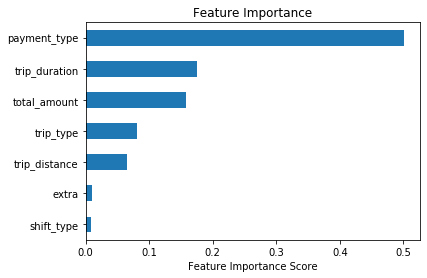

Processing time: 0:04:38.802258


In [13]:
# Optimization and Training of the Classifier
from sklearn.ensemble import GradientBoostingClassifier
print('Optimizing the classifier...')

train = data.copy() # making a copy of the training dataset
# since this dataset is comprised of some 600k obs, i will select a small smaple size to carry on model traning 
# and 5 folds cross validation because training GBM takes longer because trees are built sequentially.
train = train.loc[np.random.choice(train.index,size=100000,replace=False)]

# initiate the timing
tic = dt.datetime.now()

# for predictors, start with the candidates identified during EDA
predictors = ['payment_type','total_amount','trip_duration','trip_distance','extra',
             'shift_type','trip_type']
# set the response variable - it will be used later in the optimization process
response = 'with_tip'


# optimize n_estimator through grid search
param_test = {'n_estimators':range(30,151,20)} # define range over which number of trees is to be optimized


# initiate the classification model
model_cls = GradientBoostingClassifier(
                learning_rate=0.1, # shrinking contribution of each tree
                min_samples_split=2, # min number of features required to split an internal node
                max_depth=4, # max depth of the individual regression estimator
                max_features='auto', # sqrt of number of features used at each split
                subsample=0.8, # <1 to decrease variance and increase bias
                random_state=10)

# get results of the search grid
gs_cls = optimize_num_trees(model_cls,param_test,'roc_auc',train,predictors,response)
# print optimization results
print(gs_cls.cv_results_, gs_cls.best_params_, gs_cls.best_score_)

# cross validate the best model with optimized number of estimators
modelfit(gs_cls.best_estimator_,train,predictors,response,'roc_auc')

# save the best estimator on disk as pickle fpr later use
with open('my_classifier.pkl','wb') as fid:
    pickle.dump(gs_cls.best_estimator_,fid)
    fid.close()
    
print('Processing time:', dt.datetime.now()-tic)

The bar chart above represents the variable importance for this Gradient Boosting model. We see the mean decrease in Gini index for each variable, relative to the largest. The first three variables with the largest mean decrease in Gini index and therefore the most important variables are **payment type, trip duration, and total amount.** The output shows that the optimum number of trees is **110**.

Let's now test the model's performance on a data it has never seen (test dataset) and get the resulting ROC-AUC:

In [14]:
# testing on a different dataset
indices = data.index[~data.index.isin(train.index)]
test = data.loc[np.random.choice(indices,size=100000,replace=False)]

ypred = gs_cls.best_estimator_.predict(test[predictors])

print('ROC-AUC:', metrics.roc_auc_score(ypred,test.with_tip))

ROC-AUC: 0.9618215992784489


### Regression Model
Using a similar pipeline of optimization as in the classification model, a RandomForest (RF) model was constructed. RF model train each tree independently, using a random sample of the data. This randomness helps the model become more robust than a single decision tree, and less likely to overfit on training data. RF is easier to tune compared to GBM in that RF has only two tuning parameters, the number of trees and the number of features to be selected at each node.

**Worth Noting:**

* Sample size of training and optimization was chosen as 100000. This is a small sample size given the amount of observations we have (~600k) but is representative of the general population as it was selected randomly.
* The Mean Squared Error (MSE) was used as the model validation metric

**Results:**

* **optimized number of trees:** 150
* **optimized variables:** total_amount, trip_duration, speed_mph
* **MSE on the test dataset (for model performance purposes):** 11.35

The following code shows the optimization process...

{'mean_fit_time': array([14.13854017, 18.09640346, 24.52961717, 29.87336497, 36.09073544,
       47.19317837]), 'std_fit_time': array([0.94884667, 0.46194099, 0.47423281, 0.75583727, 0.93813338,
       5.1723072 ]), 'mean_score_time': array([0.61840887, 0.48813834, 0.71066103, 0.7200346 , 1.08591609,
       1.65856605]), 'std_score_time': array([0.25605641, 0.09260029, 0.12838606, 0.02604665, 0.21456714,
       0.25736495]), 'param_n_estimators': masked_array(data=[50, 75, 100, 125, 150, 175],
             mask=[False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'n_estimators': 50}, {'n_estimators': 75}, {'n_estimators': 100}, {'n_estimators': 125}, {'n_estimators': 150}, {'n_estimators': 175}], 'split0_test_score': array([-10.53651202, -10.68728132, -10.56342697, -10.6748193 ,
       -10.46468117, -10.52712396]), 'split1_test_score': array([-13.88729473, -13.72415546, -13.73767223, -13.71611613,
       -13.76228946, -13.65149164]),

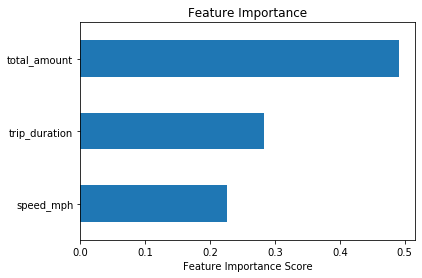

RFR test mse: 11.353023386807763
RFR r2: 0.3110123446125317
dt.datetime.now()-tic


AttributeError: 'GridSearchCV' object has no attribute 'grid_scores_'

In [42]:
train = data1.copy()
train = train.loc[np.random.choice(train.index,size=100000,replace=False)]
indices = data1.index[~data1.index.isin(train.index)]
test = data1.loc[np.random.choice(indices,size=100000,replace=False)]

train['ID'] = train.index
IDCol = 'ID'
# set the response variable
response = 'tip_percentage'
# set the predictor variables
predictors = ['VendorID','passenger_count','trip_distance','total_amount','extra','mta_tax','tolls_amount',
             'payment_type','hour_of_day','week','day_of_week','day_of_month','shift_type','trip_duration',
             'speed_mph']
predictors = ['trip_distance','tolls_amount','trip_duration','speed_mph']
predictors = ['total_amount','trip_duration','speed_mph']

# optimizing the randomForest
## initiating the time
tic = dt.datetime.now()
# importing the necessary library
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
# optimize n_estimator through grid search
param_test = {'n_estimators':range(50,200,25)} # define range over which number of trees is to be optimized
# initiate classification model
# rf_model = RandomForestRegressor(min_samples_split=2, max_depth=5, max_features='auto',random_state=10)

rf_model = RandomForestRegressor()#n_estimators=100)

# get results of the grid search
gs_rfmodel = optimize_num_trees(rf_model,param_test,'neg_mean_squared_error',train,predictors,response)

# print optimization results
print(gs_rfmodel.cv_results_, gs_rfmodel.best_params_, gs_rfmodel.best_score_)


# cross validate the best model with optimized number of estimators
modelfit(gs_rfmodel.best_estimator_,train,predictors,response,'neg_mean_squared_error')

# save the best estimator on disk as pickle for a later use
with open('my_rfmodel_reg2.pkl','wb') as fid:
    pickle.dump(gs_rfmodel.best_estimator_,fid)
    fid.close()
    
ypred = gs_rfmodel.best_estimator_.predict(test[predictors])

print("RFR test mse:",metrics.mean_squared_error(ypred,test.tip_percentage))
print("RFR r2:",metrics.r2_score(ypred,test.tip_percentage))
print("dt.datetime.now()-tic")
plot_opt_results(gs_rfmodel)

The bar chart above represents the variable importance in this RandomForest model. We see the mean decrease in Gini index for each variable, relative to the largest. The variable with the largest mean decrease in Gini index and therefore the most important variable is **total amount**. The output shows that the optimum number of trees is **150**.

### Final Model
